# Example 3: Parameter Free Bayesian Kernel Density Estimation

In [15]:
using Distributions
using Gadfly;

First, simulate some data from $p(x) = \frac{1}{2}\phi(x | 2, 0.25) + \frac{1}{2}\phi(x | 10, 1)$ [eq 28, reparametrized with precision rather than variance]:

In [16]:
# Look, this isn't world's most awesome function for sampling from a mixture model.  But it'll do.
TwoComponentGaussianMixtureSamples = function(n::Int64,
                                              w1::Float64, μ1::Float64, ϕ1::Float64,
                                              w2::Float64, μ2::Float64, ϕ2::Float64)
    if (w1 + w2 != 1.0) || (ϕ1 <= 0) || (ϕ2 <= 0) || n <= 0
        return []
    end
    
    x = zeros(n,1)
    σ1 = ϕ1^-0.5 # transform precision to standard deviation
    σ2 = ϕ2^-0.5
    for ii = 1:n
        if rand(Uniform()) <= w1
            x[ii] = rand(Normal(μ1, σ1))
        else
            x[ii] = rand(Normal(μ2, σ2))
        end
    end
    return x
end;
    

In [42]:
# sample 50 draws from this mixture
X = TwoComponentGaussianMixtureSamples(50, 0.5, 2., .25, 0.5, 10., 1.);

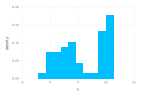

In [43]:
# cf the histogram underlying figure 6
plot(x=X, Geom.histogram(density=true, bincount=10), Guide.xlabel("x"), Guide.ylabel("density"))

In [124]:
# beginning with Xobs, simulate an additional N-1 observations from the coherent predictive distribution 
genSamplePath = function(Xobs::Array{Float64}, N::Int64, τ::Float64)
    
    allX = vcat(Xobs, zeros(N,1))
    nobs = size(Xobs,1)
    
    # build up the η and ν parameters to ii = nobs
    η = 1
    ν1 = 1
    ν2 = 1
    for ii = 1:nobs
        ρ  = (N + nobs - ii) / (N + nobs - ii + 1)
        η  = η * ρ^-1
        ν1 = ν1 * (2 - ρ) / ρ^2
        ν2 = ν2 * ρ^-2
    end
    
    
    # now do the forward simulations
    for ii = (nobs + 1):(nobs + N - 1)
        u = sample(allX[1:(ii - 1)]) # could do a bunch of these in parallel      
        
        ρ  = (N + nobs - ii) / (N + nobs - ii + 1)
        η  = η * ρ^-1
        ν1 = ν1 * (2 - ρ) / ρ^2
        ν2 = ν2 * ρ^-2
        ν = ν1 - ν2
        μ = 2 * log(η - 1) - 0.5 * log(ν + (η - 1)^2)
        σ = sqrt(log(1 + ν / (η - 1)^2))
                    
        s = rand(LogNormal(μ, σ)) # could do a bunch of these in parallel too
        
        allX[ii,1] = rand(Normal(u, sqrt(τ * (s + 1)))) # and here too
    end

    return allX
end;

In [125]:
# given an array of points and a bandwidth parameter, return the associated Gaussian KDE function
genKDEfunction = function(X::Array{Float64}, τ::Float64)
    kdef = function(x)
        n = size(X, 1)
        d = zero(x)
        for ii = 1:n
            d = d .+ pdf(Normal(X[ii], sqrt(τ)), x)
        end
        return d ./ n
    end
    return kdef
end;

In [84]:
# Now for a grid of points, evaluate the KDE associated with a simulated sample path
xgrid = -5:.1:15
N = 1000 # number additional points to simulate
τ = 0.08 # bandwidth parameter
nsamples = 100 # number Monte Carlo draws to simulate
posterior_curves = zeros(size(xgrid,1),nsamples)
for ii = 1:nsamples
    simX = genSamplePath(X, N, τ)
    kdef = genKDEfunction(simX, τ)
    posterior_curves[:,ii] = kdef(xgrid)
end

In [86]:
# Smush these curves into a stack of layers for plotting
layers = Layer[]
for ii = 1:nsamples
    push!(layers, layer(x=xgrid, y=posterior_curves[:,ii], Geom.line)[1])
end;

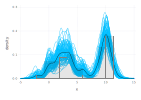

In [126]:
# overlay the sampled curves, the mean curve, with the original histogram (cf figure 5)
plot(layer(x=X, Geom.histogram(density=true, bincount=10), 
         Theme(default_color=colorant"rgba(1,1,1,0.1)", bar_highlight=colorant"grey")),
     layer(x=xgrid, y=mean(posterior_curves, 2), Geom.line, Theme(default_color=colorant"black")),
     layers,
     Guide.xlabel("x"), Guide.ylabel("density"))

Nifty, eh?  End of example the third.